# Project: Video Game Use Analysis

In [1]:
library(tidyverse)
library(tidymodels)
# library(tidyclust)
library(repr)
library(GGally)
library(janitor)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv('players.csv') |> 
    clean_names() |>
    mutate(experience = as_factor(experience), gender = as_factor(gender))

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# players_plot_exp <- ggplot(players, aes(x = experience, y = played_hours)) +
#     geom_bar(position = 'stack', stat = 'identity') + 
#     labs(x = 'Experience Level', y = 'Played Hours (hrs)', title = 'Played Hours per Experience Group')
# players_plot_gender <- ggplot(players, aes(x = gender, y = played_hours)) +
#     geom_bar(position = 'stack', stat = 'identity') + 
#     labs(x = 'Gender', y = 'Played Hours (hrs)', title = 'Played Hours per Gender')
# players_plot_age <- ggplot(players, aes(x = age, y = played_hours)) +
#     geom_bar(position = 'stack', stat = 'identity') + 
#     labs(x = 'Age (yrs)', y = 'Played Hours (hrs)', title = 'Played Hours per Age')

In [4]:
# options(repr.plot.width = 15, repr.plot.height = 7)
# plot_grid(players_plot_exp, players_plot_gender, players_plot_age, ncol = 3)

In [5]:
sessions <- read_csv('sessions.csv') |> 
    clean_names() |>
    select(start_time:end_time) |>
    separate(start_time, into = c('start_date', 'start_time'), sep = ' ') |>
    separate(end_time, into = c('end_date', 'end_time'), sep = ' ') |>
    separate(start_time, c('start_hour', 'start_min'), ':') |>
    separate(end_time, c('end_hour', 'end_min'), ':')

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
sessions_hour <- sessions |>
    select(start_hour, end_hour) |>
    map_df(as.numeric)
head(sessions_hour)

start_hour,end_hour
<dbl>,<dbl>
18,18
23,23
17,17
3,3
16,16
15,17


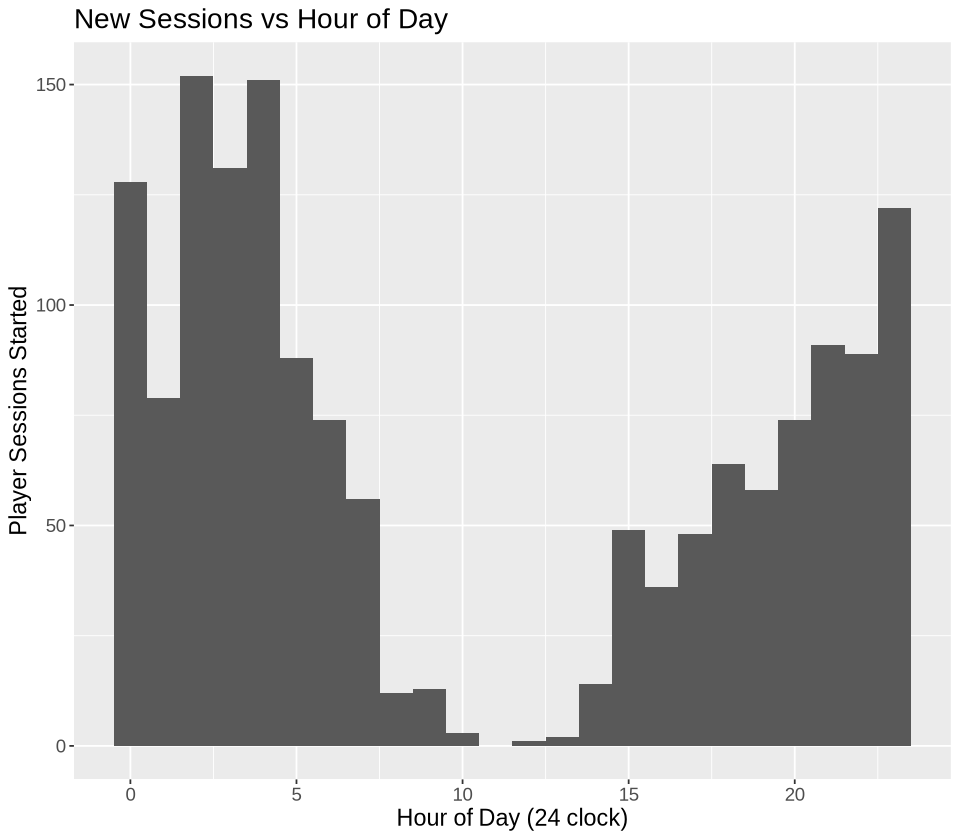

In [8]:
options(repr.plot.width = 8, repr.plot.height = 7)

new_sessions_plot <- sessions_hour |>
    ggplot(aes(x = start_hour)) + 
    geom_histogram(binwidth = 1) + 
    labs(x = 'Hour of Day (24 clock)', y = 'Player Sessions Started', title = 'New Sessions vs Hour of Day') + 
    theme(text = element_text(size = 14)) 
new_sessions_plot

In [14]:
new_sessions_count <- sessions_hour |>
    group_by(start_hour) |>
    summarize(player_count = n()) 

In [15]:
sessions_split <- initial_split(new_sessions_count, prop = 0.75, strata = player_count)
sessions_training <- training(sessions_split)
sessions_testing <- testing(sessions_split)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 1 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


In [29]:
sessions_kspec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')
sessions_recipe <- recipe(player_count ~ start_hour, data = sessions_training)

sessions_vfold <- vfold_cv(sessions_training, v = 5, strata = player_count)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

k_min <- workflow() |>
    add_model(sessions_kspec) |>
    add_recipe(sessions_recipe) |>
    tune_grid(resamples = sessions_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1) |> 
    select(neighbors) |>
    pull()

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 0 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”
→ A | warning: 10 samples were requested but there were 13 rows in the data. 8 will be used.

There were issues with some computations   A: x1

→ B | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1
There were issues with some computations   A: x2   B: x1

→ C | warning: 10 samples were requested but there were 14 rows in the data. 9 will be used.

There were issues with some computations   A: x2   B: x1
There were issues with some computations   A: x2   B: x1   C: x3





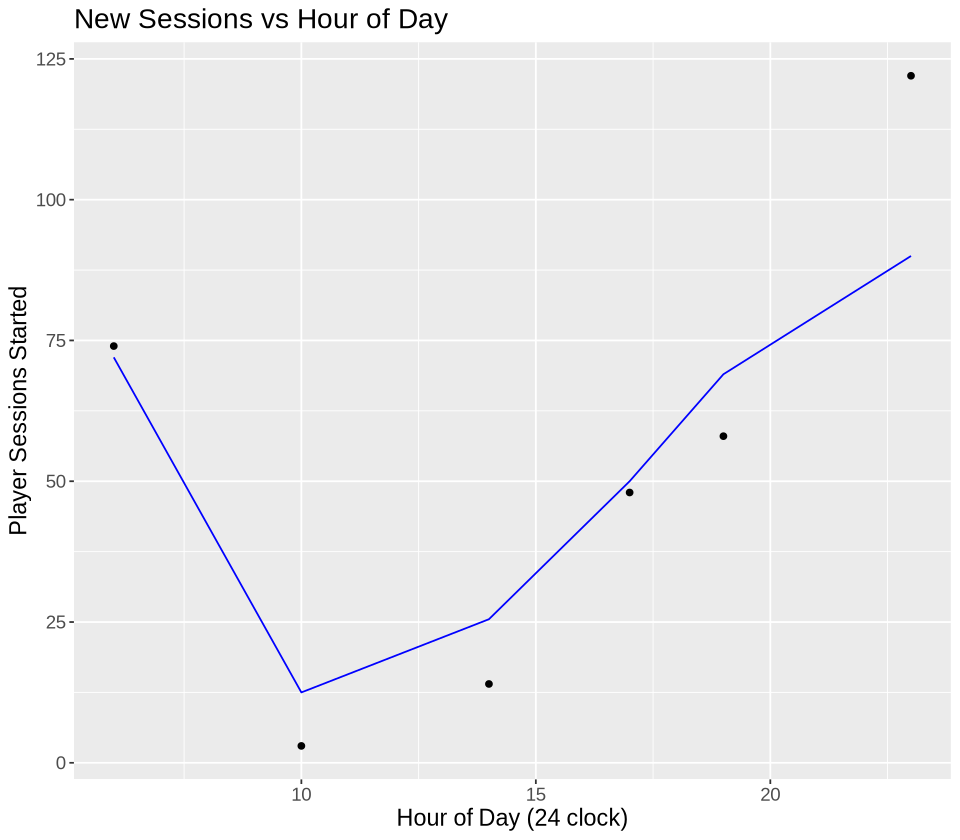

In [33]:
sessions_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = k_min) |>
    set_engine('kknn') |>
    set_mode('regression')

sessions_fit <- workflow() |>
    add_model(sessions_spec) |>
    add_recipe(sessions_recipe) |>
    fit(data = sessions_training)

sessions_predict <- sessions_fit |>
    predict(sessions_testing) |>
    bind_cols(sessions_testing)

sessions_plot_pred <- sessions_predict |>
    ggplot(aes(x = start_hour, y = player_count)) +
    geom_point() + geom_line(aes(y = .pred), color = 'blue') +
    labs(x = 'Hour of Day (24 clock)', y = 'Player Sessions Started', 
         title = 'New Sessions vs Hour of Day') + 
    theme(text = element_text(size = 14)) 
sessions_plot_pred